In [1]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing

In [2]:
y = pd.read_csv('data/y.csv').iloc[:, 0]
FS1 = pd.read_csv('data/FS1.csv', dtype=float)
PS2 = pd.read_csv('data/PS2.csv', dtype=float)

## Merge all features

Combine all features from FS1 and PS2 in a single vector.

In [3]:
def merge_features(df1, df2):
    return pd.merge(df1, df2, left_index=True, right_index=True)

X = merge_features(FS1, PS2)
X.shape

(2205, 6600)

In [4]:
X

,1_FS1,2_FS1,3_FS1,4_FS1,5_FS1,6_FS1,7_FS1,8_FS1,9_FS1,10_FS1,...,5991_PS2,5992_PS2,5993_PS2,5994_PS2,5995_PS2,5996_PS2,5997_PS2,5998_PS2,5999_PS2,6000_PS2
0,8.990,0.770,0.641,0.006,0.000,0.000,0.001,0.003,0.001,0.001,...,125.02,125.00,125.10,125.09,124.98,124.91,124.98,125.11,125.14,125.10
1,8.919,0.815,0.709,0.009,0.004,0.000,0.001,0.000,0.000,0.001,...,124.80,124.88,125.13,125.22,125.09,124.98,125.06,125.13,125.09,125.04
2,9.179,0.683,0.528,0.008,0.003,0.001,0.003,0.003,0.004,0.006,...,124.61,124.69,124.74,124.71,124.59,124.64,124.74,124.73,124.77,124.88
3,9.034,0.728,0.595,0.009,0.001,0.004,0.003,0.003,0.003,0.001,...,124.82,124.79,124.69,124.69,124.77,124.83,124.69,124.53,124.51,124.59
4,8.729,0.705,0.446,0.014,0.007,0.003,0.001,0.003,0.001,0.000,...,124.80,124.67,124.49,124.56,124.69,124.62,124.45,124.41,124.47,124.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,8.173,1.024,0.834,0.009,0.000,0.001,0.000,0.003,0.001,0.000,...,125.57,125.51,125.38,125.43,125.59,125.61,125.53,125.50,125.60,125.73
2201,8.317,0.883,0.799,0.008,0.005,0.000,0.000,0.000,0.000,0.001,...,125.86,125.77,125.74,125.81,125.77,125.66,125.58,125.58,125.55,125.44
2202,8.170,0.686,0.583,0.011,0.000,0.003,0.004,0.000,0.000,0.000,...,125.66,125.73,125.77,125.81,125.94,126.04,125.98,125.84,125.84,125.94
2203,8.496,0.543,0.366,0.009,0.005,0.000,0.000,0.000,0.001,0.003,...,125.55,125.56,125.58,125.74,125.84,125.73,125.66,125.73,125.86,125.91


## Train/test split

First 2k samples will be used for the training, rest for the test.

In [5]:
def train_test_split(X, y, n=2000):

    y_train = y.iloc[:n]
    X_train = X.iloc[:n, :]

    y_test = y.iloc[n:]
    X_test = X.iloc[n:, :]

    print('X_train: ', X_train.shape)
    print('y_train: ', y_train.shape)
    print('X_test: ', X_test.shape)
    print('y_test: ', y_test.shape)

    return X_train, y_train, X_test, y_test

In [6]:
X_train, y_train, X_test, y_test = train_test_split(X, y)

X_train:  (2000, 6600)
y_train:  (2000,)
X_test:  (205, 6600)
y_test:  (205,)


Check data distribution in training and test sets:

In [7]:
pd.concat(
    [
        y.value_counts(normalize=True).rename('all'), 
        y_train.value_counts(normalize=True).rename('train'), 
        y_test.value_counts(normalize=True).rename('test')
    ]
    , axis=1).round(2)

,all,train,test
valve condition,,,
1,0.51,0.53,0.36
0,0.49,0.47,0.64


Train set has approximatevely the same distribution of target variable as the whole dataset. However the test set has significantly less positive examples.

# Base model

## Choice of the evaluation metric

Since the dataset is well balanced we could start with accuracy, precision or recall. For simplicity let's start with acuracy.

## Model

### Logistic regression

In [8]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [9]:
print('Train set accuracy = ', clf.score(X_train, y_train))
print('Test  set accuracy = ', clf.score(X_test, y_test))

Train set accuracy =  1.0
Test  set accuracy =  1.0


Confusion matrix

In [10]:
y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)

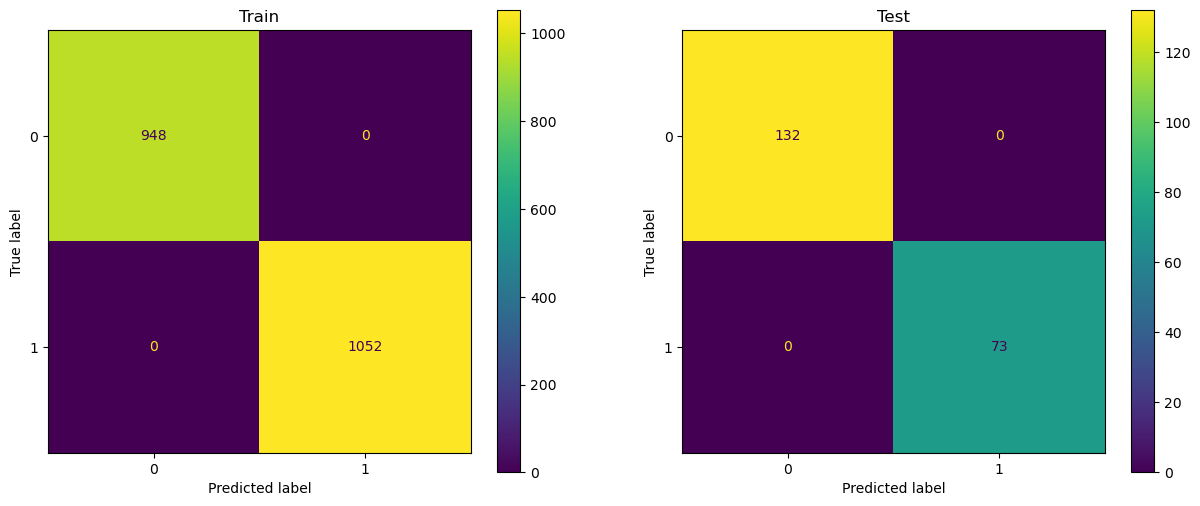

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axs[0].set_title("Train")
axs[1].set_title("Test")
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax=axs[0])
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=axs[1])
plt.show()

Cross-validation score:

In [13]:
scores = cross_validate(LogisticRegression(random_state=0, max_iter=300), X, y, cv=5, scoring='accuracy', return_train_score=True)

pd.DataFrame(scores)[['train_score', 'test_score']]

,train_score,test_score
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


Base model acheives perfect score.

# Base model exploration and improvement

1. Explore the data to understand how LR can acheive perfect separation of target classes.
1. Try to improve base model (simplify, smth else?)

## Reduce time resolution

Currently there are too many features. We ould try to reduce their number by decreasing time resolution, first in PS2, then both in FS1 and PS2.

In [13]:
def reduce_time_resolution(df, stride):
    if stride == 1:
        return df
    
    df_reduced = []
    for i in range(0, df.shape[1], stride):
        avg_cols = df.iloc[:, i:i+stride].mean(axis=1)
        avg_cols.name = df.iloc[:, i].name
        df_reduced.append(avg_cols)

    df_reduced = pd.concat(df_reduced, axis=1)

    return df_reduced

After a series of tests I have converged to these values, which correspond to the same time resolution in FS1 and PS2 equal to 5 sec.

In [14]:
FS1_reduced = reduce_time_resolution(FS1, stride=50)
PS2_reduced = reduce_time_resolution(PS2, stride=500)

FS1_reduced.shape, PS2_reduced.shape

((2205, 12), (2205, 12))

Combine FS1 and PS2 features:

In [15]:
X = merge_features(FS1_reduced, PS2_reduced)
X.shape

(2205, 24)

In [16]:
X_train, y_train, X_test, y_test = train_test_split(X, y)

X_train:  (2000, 24)
y_train:  (2000,)
X_test:  (205, 24)
y_test:  (205,)


### LR with coarser time resolution

In [17]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [18]:
print('Train set accuracy = ', clf.score(X_train, y_train))
print('Test  set accuracy = ', clf.score(X_test, y_test))

Train set accuracy =  1.0
Test  set accuracy =  1.0


Cross-validation score:

In [19]:
scores = cross_validate(LogisticRegression(random_state=0, max_iter=300), X, y, cv=5, scoring='accuracy', return_train_score=True)

pd.DataFrame(scores)[['train_score', 'test_score']]

,train_score,test_score
0,1.0,1.000000
1,1.0,0.857143
2,1.0,1.000000
3,1.0,1.000000
4,1.0,1.000000


## Feature selection

Probably we could further simplify the model by selecting only the most important features.

For LR we can estimate feature importance by the value of the coefficient corresponding to this feature. Features must be standartized before this.

In [20]:
X = merge_features(FS1_reduced, PS2_reduced)
X.shape

(2205, 24)

In [21]:
X_train, y_train, X_test, y_test = train_test_split(X, y)

X_train:  (2000, 24)
y_train:  (2000,)
X_test:  (205, 24)
y_test:  (205,)


In [22]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=300)).fit(X_train, y_train)

In [23]:
print('Train set accuracy = ', clf.score(X_train, y_train))
print('Test  set accuracy = ', clf.score(X_test, y_test))

Train set accuracy =  1.0
Test  set accuracy =  1.0


How does the model "see" the decision:

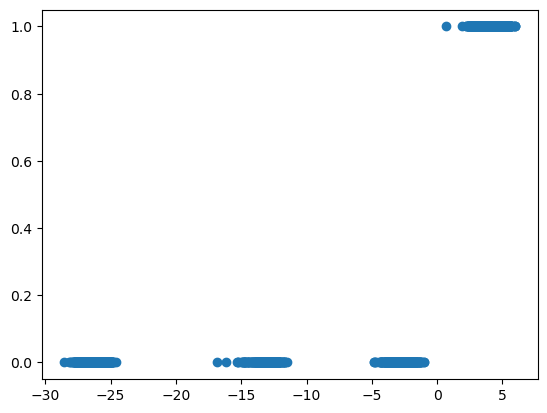

In [24]:
plt.scatter(clf['logisticregression'].coef_ @ clf['standardscaler'].transform(X).T + clf['logisticregression'].intercept_, y)

In [25]:
scores = cross_validate(make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=300)), X, y, cv=5, scoring='accuracy', return_train_score=True)

pd.DataFrame(scores)[['train_score', 'test_score']]

,train_score,test_score
0,1.0,0.959184
1,1.0,0.854875
2,1.0,1.000000
3,1.0,1.000000
4,1.0,1.000000


Feature importance:

<Axes: xlabel='feature'>

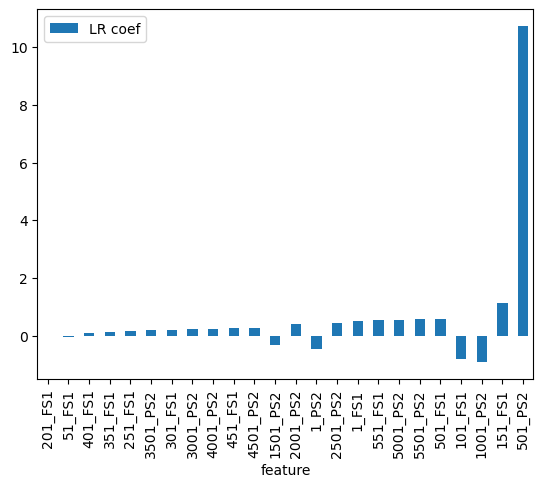

In [26]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'LR coef': clf['logisticregression'].coef_[0]})
feature_importance['LR coef abs'] = feature_importance['LR coef'].abs()

feature_importance.sort_values(by=['LR coef abs']).plot.bar(x='feature', y='LR coef')

It appears that the most important information comes from PS2 in the time range between 500 and 1000 sample.

What happens at this moment? Examination of the figure below shows that the most important events happen between 900 and 1000.

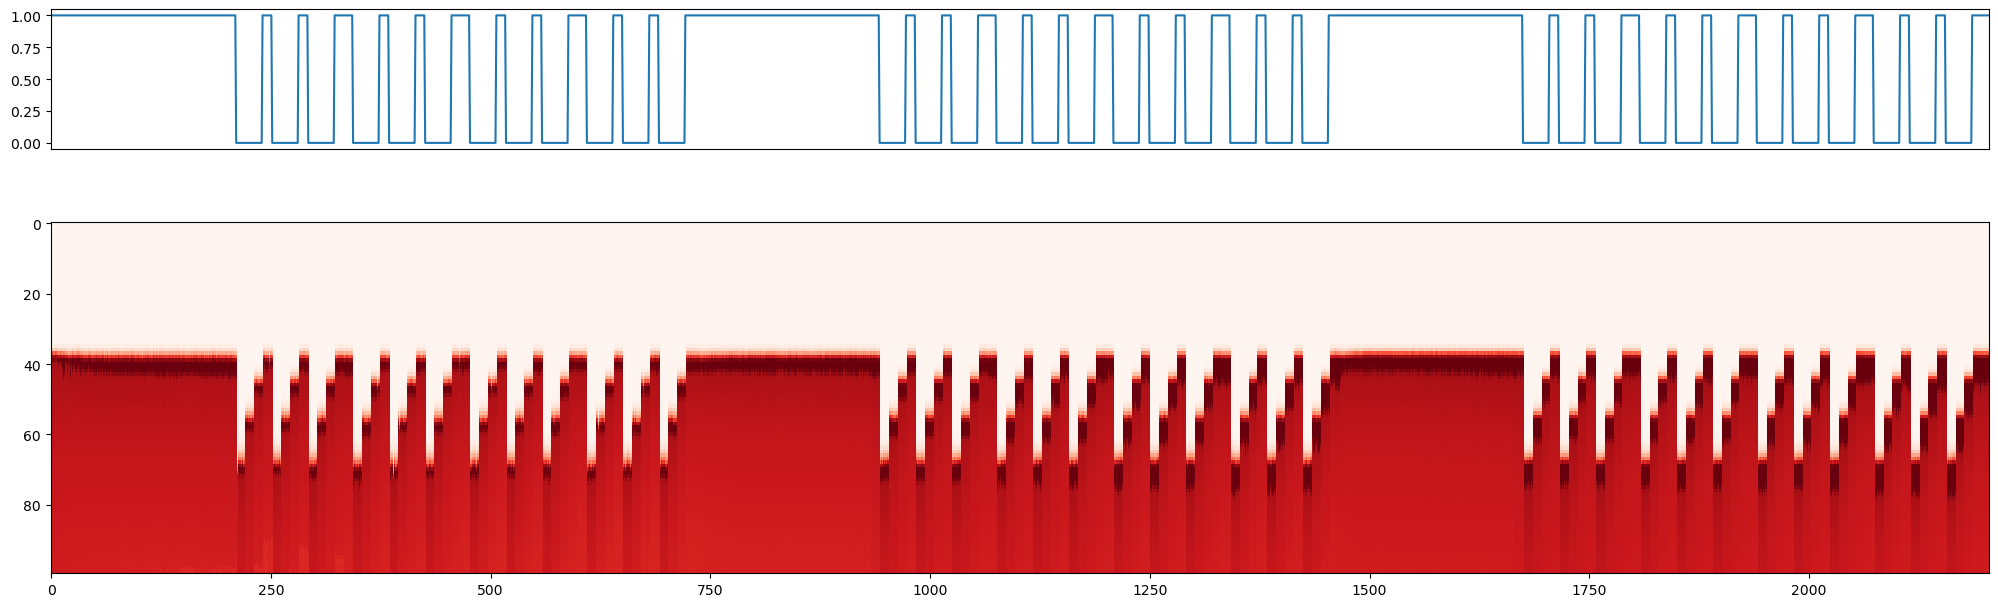

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=1, height_ratios=[1, 4], figsize=(20, 7))

axs[1].imshow(PS2.iloc[:, 900:1000].T, interpolation="none", cmap='Reds', aspect=4)

axs[0].plot(y)
axs[0].set_xlim(0, y.size)
axs[0].get_xaxis().set_visible(False)

fig.tight_layout()

Same moment for FS1. We observe the same phenomena but with more noise.

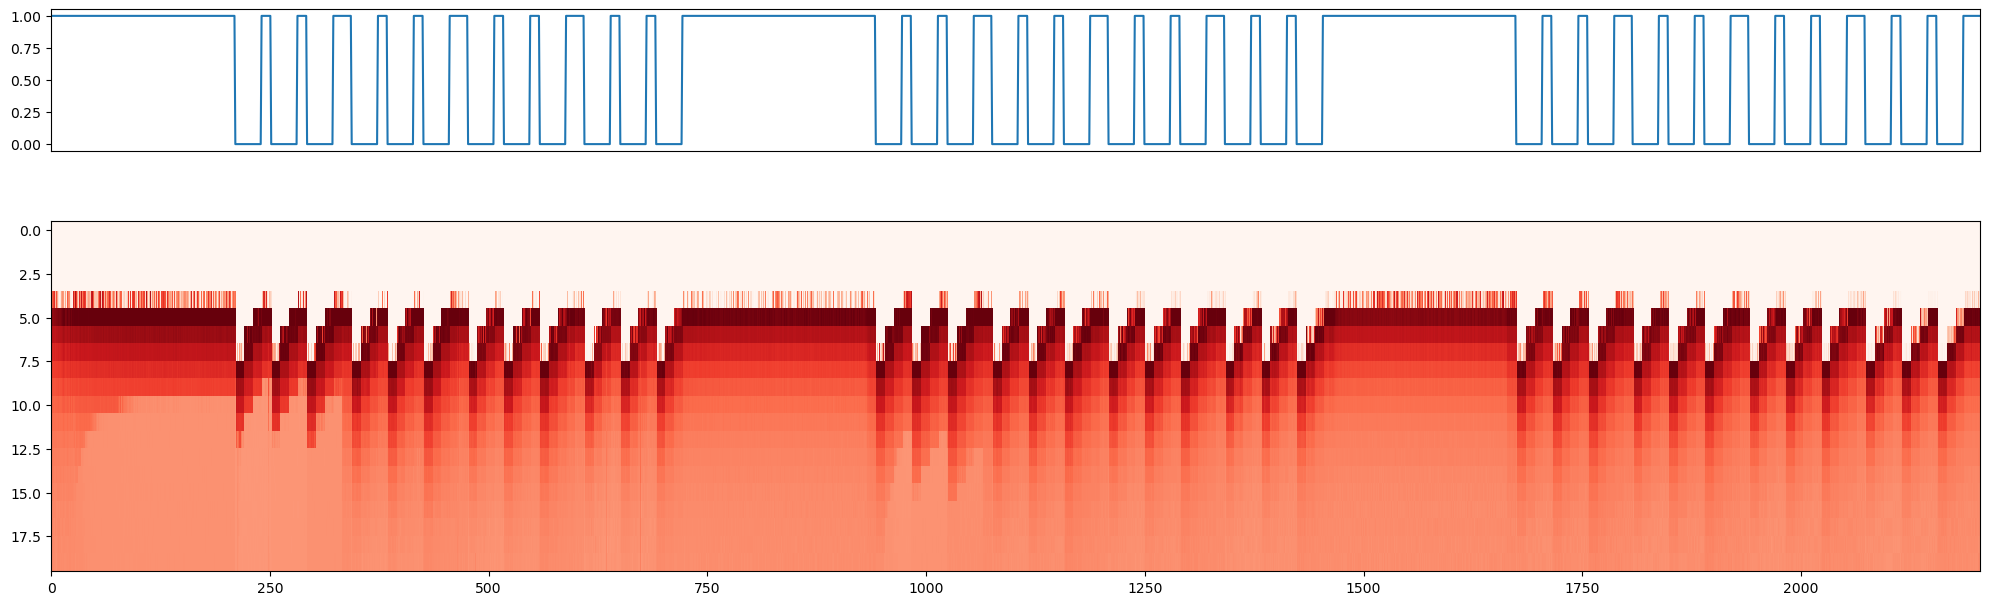

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=1, height_ratios=[1, 4], figsize=(20, 7))

axs[1].imshow(FS1.iloc[:, 90:110].T, interpolation="none", cmap='Reds', aspect=20)

axs[0].plot(y)
axs[0].set_xlim(0, y.size)
axs[0].get_xaxis().set_visible(False)

fig.tight_layout()

Another, more clear way to visualise the decisive moment in PS2 and FS1:

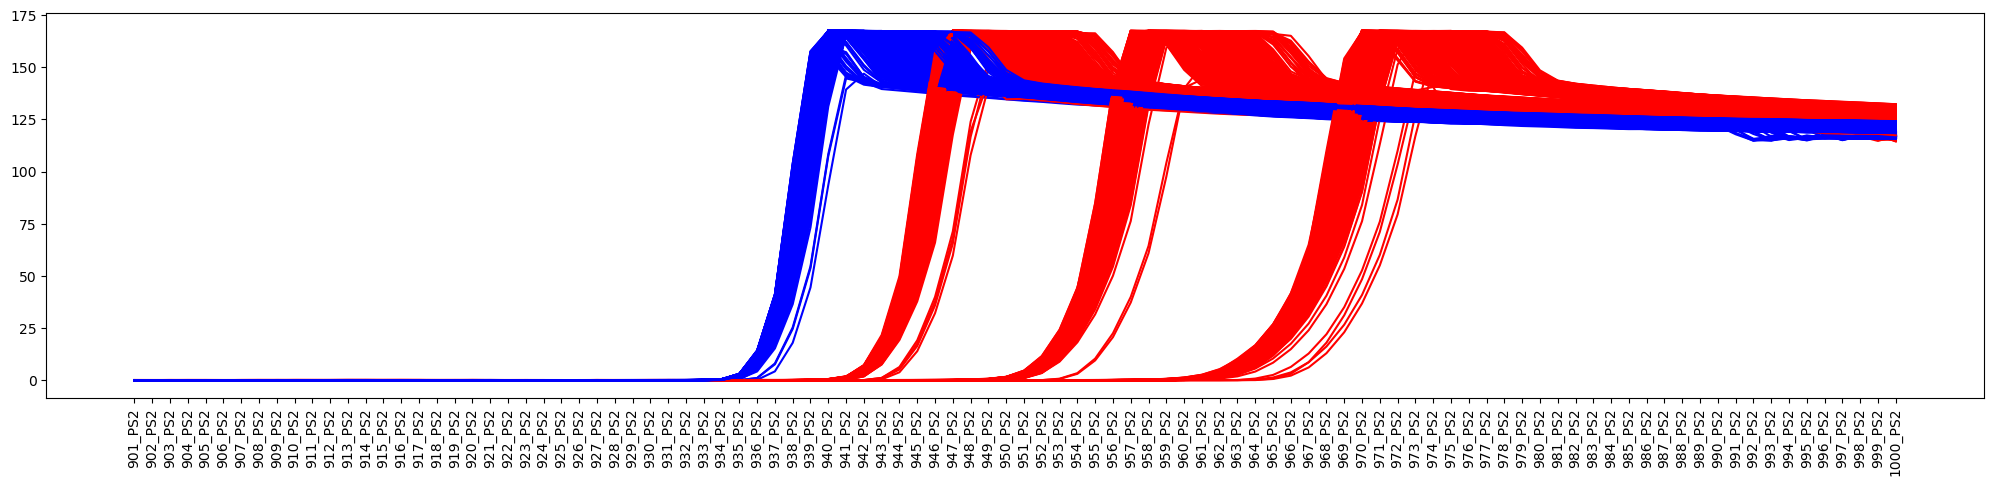

In [29]:
fig, ax = plt.subplots(figsize=(25, 5))
for i, s in PS2.iloc[:, 900:1000].iterrows():
    c = 'r' if y[i] == 0 else 'b'
    ax.plot(s, c=c)
ax.tick_params(axis='x', rotation=90)

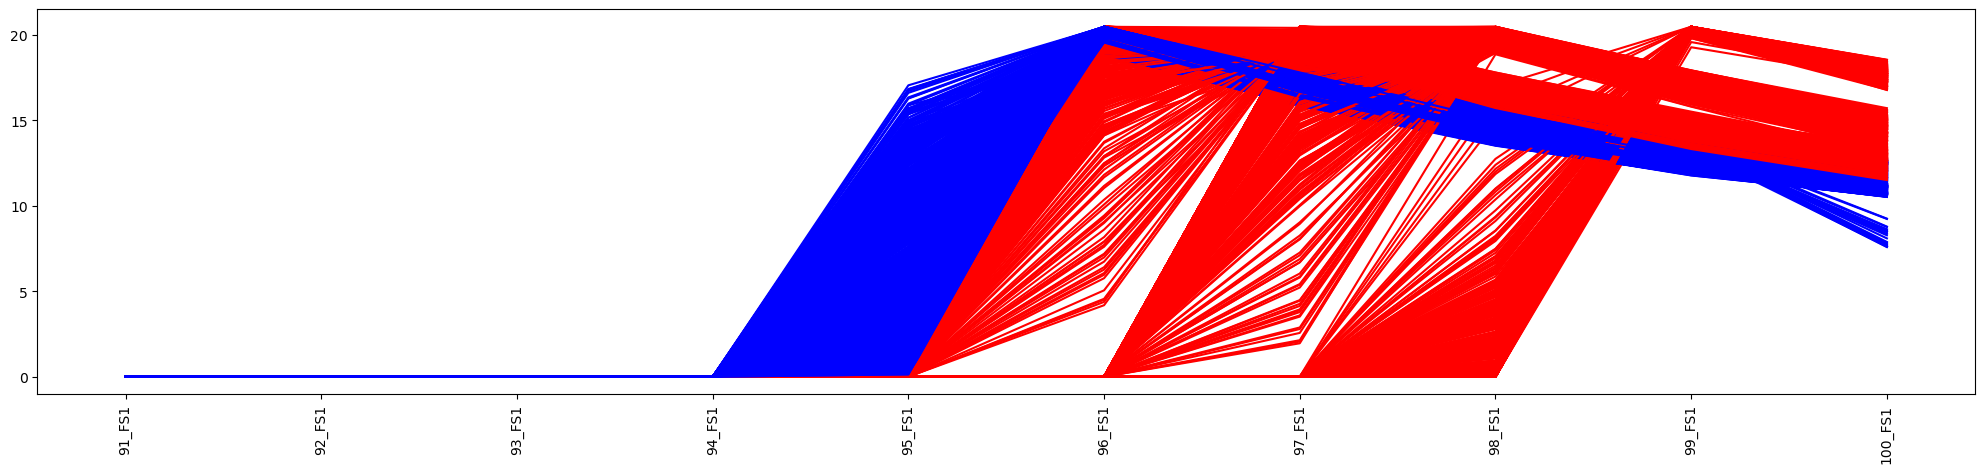

In [30]:
fig, ax = plt.subplots(figsize=(25, 5))
for i, s in FS1.iloc[:, 90:100].iterrows():
    c = 'r' if y[i] == 0 else 'b'
    ax.plot(s, c=c)
ax.tick_params(axis='x', rotation=90)

Try to use PS2 in the time range between 500 and 1000 sample as the only feature.

**Note of caution.**

Features are correlated (since they are points on a time series) and hence the values of the coefficients of an LR model might not be reliable.

Check correlations:

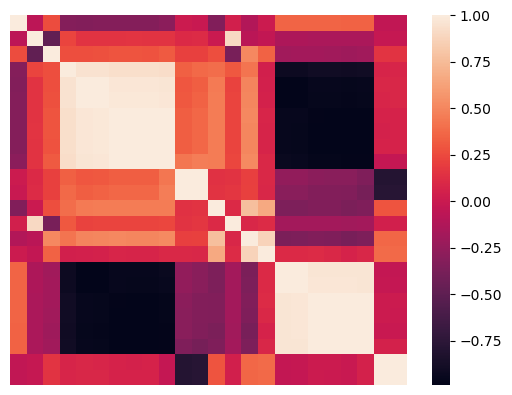

In [31]:
corrs = X_train.corr('pearson')
sns.heatmap(corrs, annot=False, xticklabels=False, yticklabels=False);

Saturate contrast:

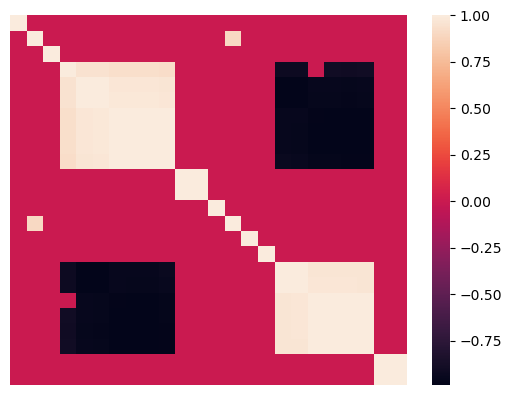

In [32]:
corrs_abs = corrs.abs()
corrs[corrs_abs < 0.9] = 0

sns.heatmap(corrs, annot=False, xticklabels=False, yticklabels=False);

Actually there are not that much correlations as I was suspecting.

## Keep PS2 only

In [33]:
X = PS2_reduced.copy()
X.shape

(2205, 12)

In [34]:
X_train, y_train, X_test, y_test = train_test_split(X, y)

X_train:  (2000, 12)
y_train:  (2000,)
X_test:  (205, 12)
y_test:  (205,)


In [35]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=300)).fit(X_train, y_train)

In [36]:
print('Train set accuracy = ', clf.score(X_train, y_train))
print('Test  set accuracy = ', clf.score(X_test, y_test))

Train set accuracy =  1.0
Test  set accuracy =  1.0


In [37]:
scores = cross_validate(make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=300)), X, y, cv=5, scoring='accuracy', return_train_score=True)

pd.DataFrame(scores)[['train_score', 'test_score']]

,train_score,test_score
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


Feature importance:

<Axes: xlabel='feature'>

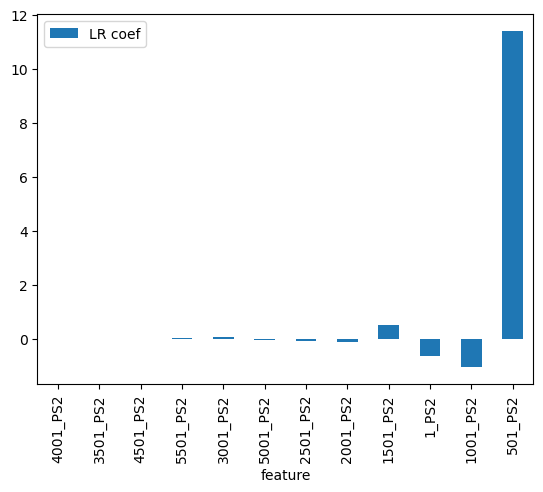

In [38]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'LR coef': clf['logisticregression'].coef_[0]})
feature_importance['LR coef abs'] = feature_importance['LR coef'].abs()

feature_importance.sort_values(by=['LR coef abs']).plot.bar(x='feature', y='LR coef')

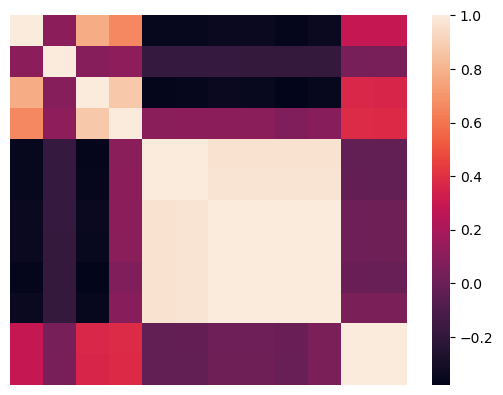

In [39]:
corrs = X_train.corr('pearson')
sns.heatmap(corrs, annot=False, xticklabels=False, yticklabels=False);

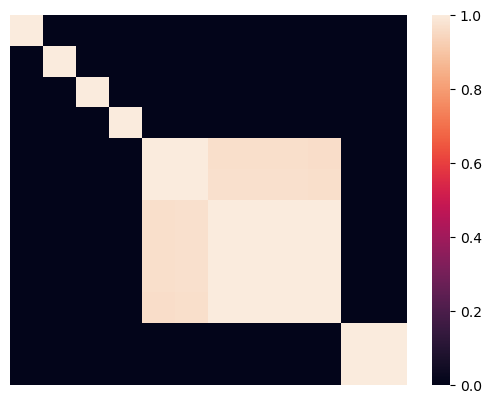

In [40]:
corrs_abs = corrs.abs()
corrs[corrs_abs < 0.95] = 0

sns.heatmap(corrs, annot=False, xticklabels=False, yticklabels=False);

## Keep one feature only

In [41]:
X = PS2_reduced.iloc[:, [1]].copy()
X.shape

(2205, 1)

In [42]:
X_train, y_train, X_test, y_test = train_test_split(X, y)

X_train:  (2000, 1)
y_train:  (2000,)
X_test:  (205, 1)
y_test:  (205,)


In [43]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=300)).fit(X_train, y_train)

In [44]:
print('Train set accuracy = ', clf.score(X_train, y_train))
print('Test  set accuracy = ', clf.score(X_test, y_test))

Train set accuracy =  1.0
Test  set accuracy =  1.0


In [45]:
scores = cross_validate(make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=300)), X, y, cv=5, scoring='accuracy', return_train_score=True)

pd.DataFrame(scores)[['train_score', 'test_score']]

,train_score,test_score
0,1.000000,0.997732
1,0.999433,0.997732
2,1.000000,1.000000
3,1.000000,1.000000
4,1.000000,0.997732


## Improve model robustness to PS2 distribution

We can try to get a perfect model by:

1. More careful filtering (coarsening) of PS2.
1. Selection of the most important feature.

Viasual exploration of the plot below suggest that stride=3 might be a good choice.

In [46]:
PS2_reduced = reduce_time_resolution(PS2, stride=3)
PS2_reduced.shape

(2205, 2000)

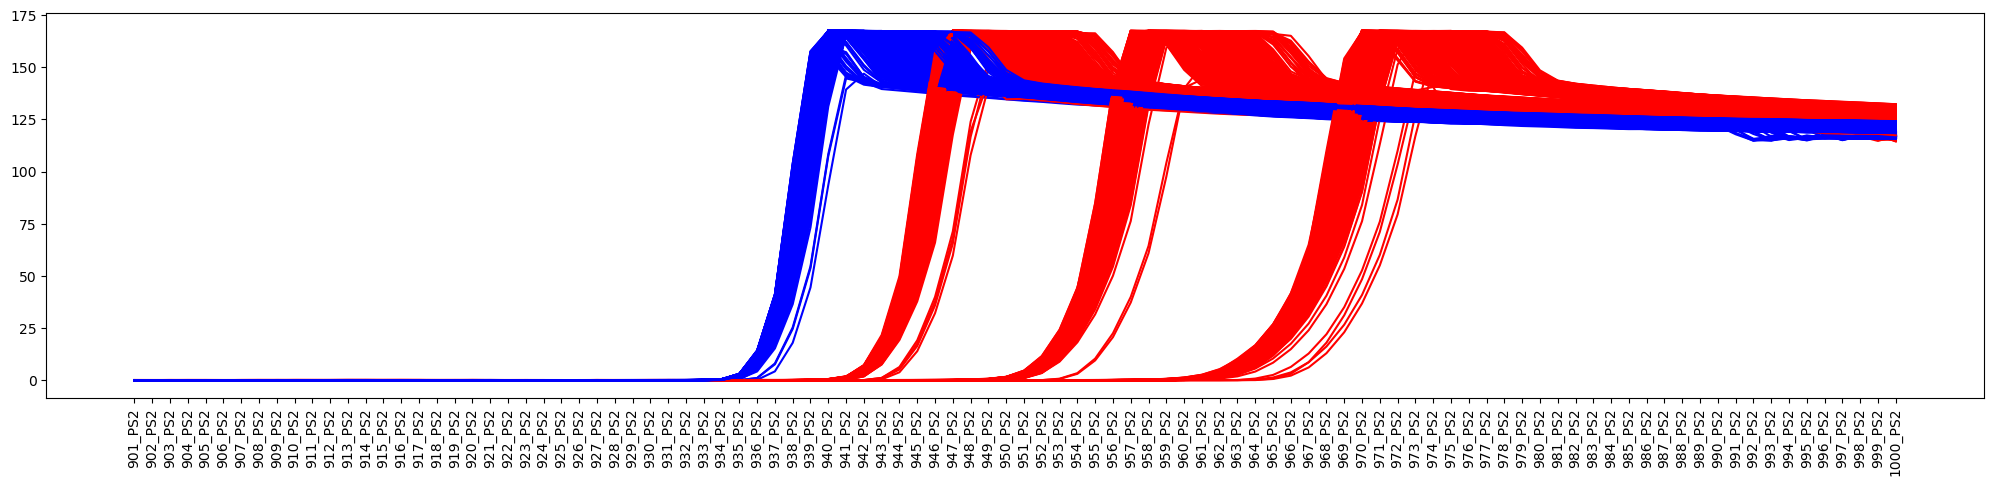

In [47]:
fig, ax = plt.subplots(figsize=(25, 5))
for i, s in PS2.iloc[:, 900:1000].iterrows():
    c = 'r' if y[i] == 0 else 'b'
    ax.plot(s, c=c)
ax.tick_params(axis='x', rotation=90)

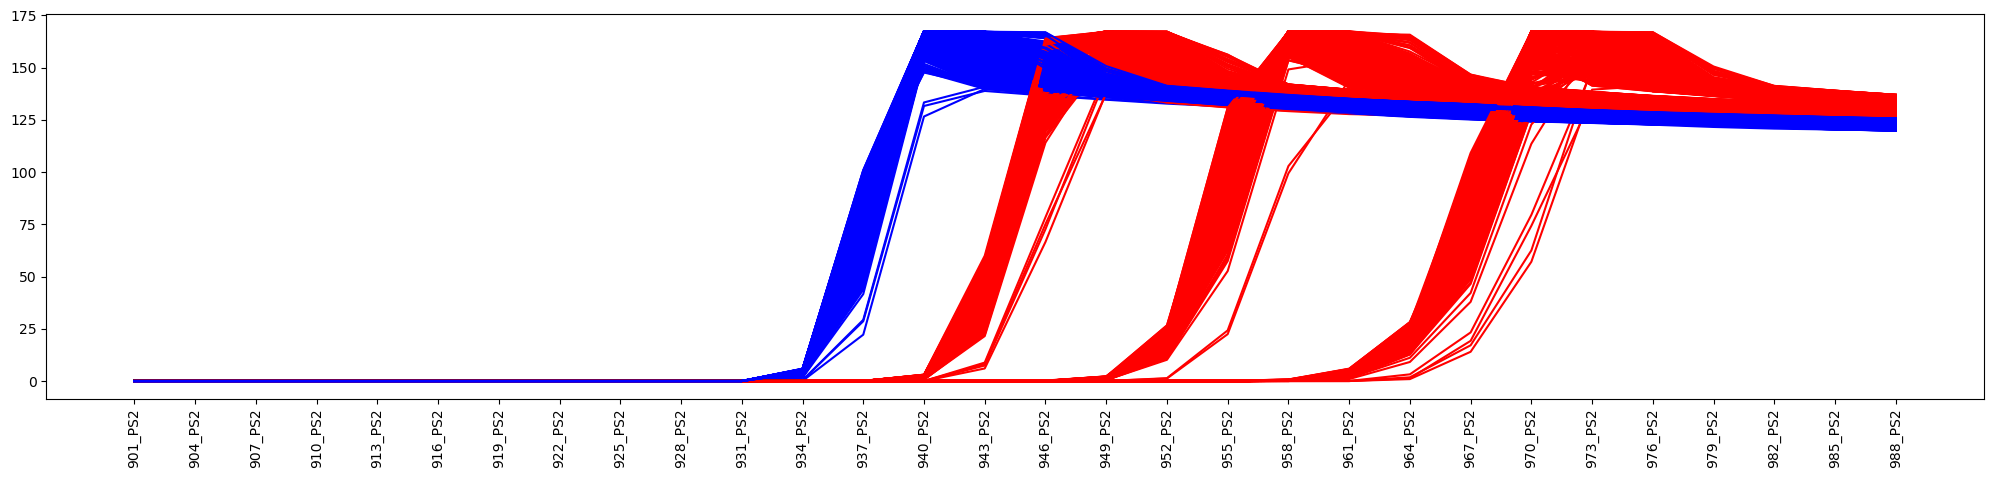

In [48]:
fig, ax = plt.subplots(figsize=(25, 5))
for i, s in PS2_reduced.iloc[:, 300:330].iterrows():
    c = 'r' if y[i] == 0 else 'b'
    ax.plot(s, c=c)
ax.tick_params(axis='x', rotation=90)

Zoom on the values close to 0 to choose a good threshold:

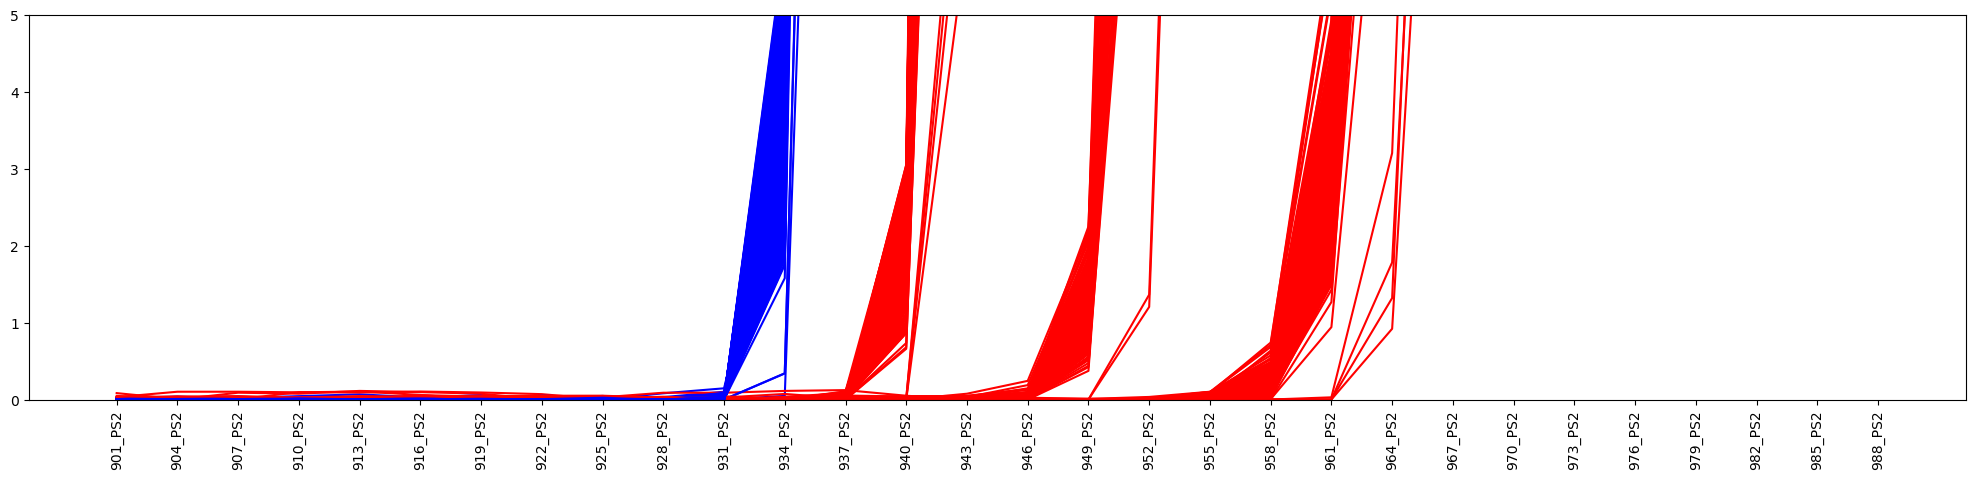

In [49]:
fig, ax = plt.subplots(figsize=(25, 5))
for i, s in PS2_reduced.iloc[:, 300:330].iterrows():
    c = 'r' if y[i] == 0 else 'b'
    ax.plot(s, c=c)
ax.set_ylim(0, 5)
ax.tick_params(axis='x', rotation=90)

From the plot above it seems that the feature 937_PS2 might be the most important one, with a threshold > 5.

Train LR on filtered PS2.

In [50]:
X = PS2_reduced.copy()
X.shape

(2205, 2000)

In [51]:
X_train, y_train, X_test, y_test = train_test_split(X, y)

X_train:  (2000, 2000)
y_train:  (2000,)
X_test:  (205, 2000)
y_test:  (205,)


In [52]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=300)).fit(X_train, y_train)

In [53]:
print('Train set accuracy = ', clf.score(X_train, y_train))
print('Test  set accuracy = ', clf.score(X_test, y_test))

Train set accuracy =  1.0
Test  set accuracy =  1.0


In [54]:
scores = cross_validate(make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=300)), X, y, cv=5, scoring='accuracy', return_train_score=True)

pd.DataFrame(scores)[['train_score', 'test_score']]

,train_score,test_score
0,1.0,0.995465
1,1.0,0.988662
2,1.0,1.000000
3,1.0,1.000000
4,1.0,1.000000


Feature importance:

<Axes: xlabel='feature'>

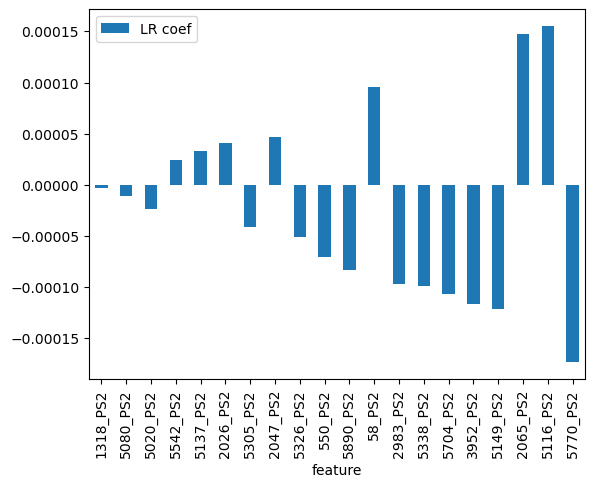

In [55]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'LR coef': clf['logisticregression'].coef_[0]})
feature_importance['LR coef abs'] = feature_importance['LR coef'].abs()

feature_importance.sort_values(by=['LR coef abs']).iloc[:20, :].plot.bar(x='feature', y='LR coef')

Suprisingly we don't find the feature 937_PS2 among most important features. Moreover, the CV scores are not perfect. This confirms that we suffer from feature collinearity.

Draw correlation plot to confirm this:

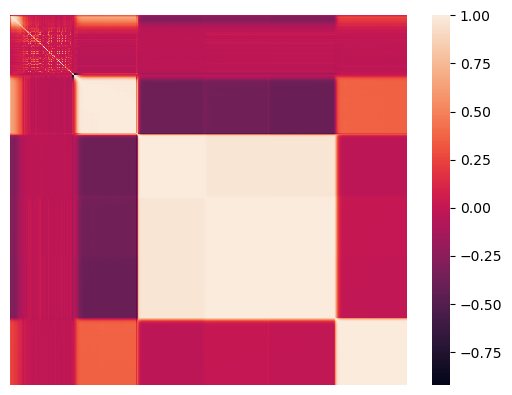

In [56]:
corrs = X_train.corr('pearson')
sns.heatmap(corrs, annot=False, xticklabels=False, yticklabels=False);

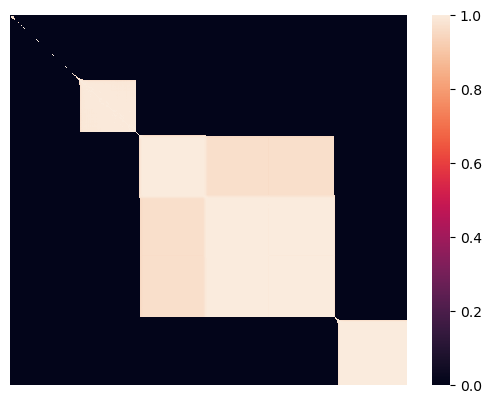

In [57]:
corrs_abs = corrs.abs()
corrs[corrs_abs < 0.95] = 0

sns.heatmap(corrs, annot=False, xticklabels=False, yticklabels=False);

Manually select one feature 937_PS2 and use it to train LR model.

In [58]:
PS2_reduced.iloc[:, 312:320]

,937_PS2,940_PS2,943_PS2,946_PS2,949_PS2,952_PS2,955_PS2,958_PS2
0,94.521333,148.776667,141.423333,139.930000,138.223333,136.480000,134.793333,133.390000
1,95.577000,149.126667,140.903333,139.360000,137.993333,136.513333,135.010000,133.636667
2,87.885000,148.473333,140.300000,138.610000,137.170000,135.860000,134.570000,133.273333
3,84.569000,148.363333,140.520000,138.870000,137.323333,135.853333,134.343333,133.156667
4,87.844333,148.863333,140.023333,138.370000,136.906667,135.610000,134.380000,133.203333
...,...,...,...,...,...,...,...,...
2200,87.583000,167.380000,167.126667,154.216667,141.916667,139.473333,137.510000,135.536667
2201,93.959333,167.196667,167.213333,157.576667,142.403333,139.686667,137.693333,135.576667
2202,90.829333,167.323333,166.760000,149.530000,141.260000,138.930000,136.853333,135.113333
2203,91.720333,167.406667,167.240000,155.576667,142.186667,139.703333,137.633333,135.680000


In [59]:
X = PS2_reduced.iloc[:, [312]].copy()
X.shape

(2205, 1)

In [60]:
X_train, y_train, X_test, y_test = train_test_split(X, y)

X_train:  (2000, 1)
y_train:  (2000,)
X_test:  (205, 1)
y_test:  (205,)


In [61]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=300)).fit(X_train, y_train)

In [62]:
print('Train set accuracy = ', clf.score(X_train, y_train))
print('Test  set accuracy = ', clf.score(X_test, y_test))

Train set accuracy =  0.999
Test  set accuracy =  1.0


In [63]:
scores = cross_validate(make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=300)), X, y, cv=5, scoring='accuracy', return_train_score=True)

pd.DataFrame(scores)[['train_score', 'test_score']]

,train_score,test_score
0,0.998866,0.997732
1,0.999433,0.995465
2,0.998299,1.000000
3,0.998866,1.000000
4,0.998866,1.000000


The CV score is still not perfect.

However, manually we can create a perfect model:

In [64]:
((X > 5).iloc[:, 0] == y).all()

True

# Conclusions and next steps

* Target can be predicted by a simple decision rule based on the value of PS2 around 9-10 sec of the cycle.
* The model is somewhat sensitive to the distribution of PS2 in this time range (see CV score whare accuracy decreases slightly below 1 on some folds).
* The model might be done more robust in respect to the distribution of PS2 by a more careful choice of decision boundary.